# Database Exploration

By **Franklin Oliveira**

-----
This notebook contains some code written to I (Franklin) get accquainted with the `crustacea` database. Here you'll find some basic data treatment and adjustments that presented necessary as I started to understand the nature of the information in file <font color='blue'>'Planilha geral Atualizda FINAL com correções.xlsx'</font>.

In [1]:
import datetime
import numpy as np
import pandas as pd

from collections import defaultdict

# pacotes para visualização rápida
import seaborn as sns
import matplotlib.pyplot as plt

# Waffle Charts
from pywaffle import Waffle 
# docs: https://pywaffle.readthedocs.io/en/latest/examples/block_shape_distance_location_and_direction.html

# pacote para visualização principal
import altair as alt

# habilitando renderizador para notebook
alt.renderers.enable('notebook')

# desabilitando limite de linhas
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Importing data...

In [2]:
excel = pd.ExcelFile('Planilha geral Atualizda FINAL com correções.xlsx')
sheet_name = excel.sheet_names

print('The excel file contains the following sheets:', sheet_name)
print('\nDatabase is in sheet:', sheet_name[0])

The excel file contains the following sheets: ['Banco de Dados Colecao Carcinol', 'Planilha1']

Database is in sheet: Banco de Dados Colecao Carcinol


In [3]:
# db = excel.parse(sheet_name[0], sep=';', encoding='utf-8-sig')

# p.s.: I'm parsing a pre-treated file provided by Asla
db = pd.read_csv('db.csv', sep=',', encoding='utf-8-sig', low_memory=False)
print(f'The database has {db.shape[0]} rows and {db.shape[1]} columns.')

The database has 28689 rows and 132 columns.


In [4]:
# copying database to another variable to make a few changes keeping the original intact
crustaceas = db.copy()

<br>

### Name columns

`Determiner First Name1` e `Determiner Last Name1`

#### treating determiner's name 

In this step, we're going to put together determiner's first and last name. 

`Determiner First Name1` + `Determiner Last Name1`

Just concatenating those two columns is not satisfactory because there's some dirt in these data columns. So, let's begin by treating them...

In [5]:
def treat_names(name, pos='first'):
    '''
    Treat names keeping NaN as such.
    
    Arguments: 
        - name: name to be treated. 
        - pos (str): name position. One of ['first', 'last']
    '''
    if type(name) == str and pos == 'first':     # primeiro nome
        
        if len(name.split(' ')) > 1:             # trata se o nome é composto (+ de um nome)
            return str(name).strip().split(' ')[0].capitalize()
        else:
            return str(name).strip().capitalize()
    
    elif type(name) == str and pos == 'last':    # último sobrenome
        
        if len(name.split(' ')) > 1:             # trata se o último nome é composto (+ de um sobrenome)
            return str(name).strip().split(' ')[-1].capitalize()
        else:
            return str(name).strip().capitalize()   
    else:
        return name

applying function to the two column names

In [6]:
crustaceas['Determiner First Name1'] = crustaceas['Determiner First Name1'].apply(treat_names)
# crustaceas['Determiner First Name1'].value_counts()

In [7]:
crustaceas['Determiner Last Name1'] = crustaceas['Determiner Last Name1'].apply(lambda x:
                                                                treat_names(x, pos='last'))
# crustaceas['Determiner Last Name1'].value_counts()

In [8]:
# creating column with First and Last name for identification
crustaceas['Determiner First_and_Last Name'] = crustaceas['Determiner First Name1'] + ' ' + crustaceas['Determiner Last Name1']

<br>

## Adjusting columns names

### removing '\n'

In [11]:
crustaceas.columns = [str(col).replace(r'\n','') for col in crustaceas.columns]

#### closer look on some columns...

In [10]:
# crustaceas[['Species1', 'Species Author1', 'Type Status1', 'Qualifier1', 'Determiner First Name1',
#       'Determiner Middle1', 'Determiner Last Name1', 'Determined Date1']]

<br>

## preparing data for charts...

### Column: `Type Status1`

In [12]:
crustaceas['Type Status1'].value_counts().head()

Paratipo    433
Holotipo    203
ParaTIPO    142
PARATIPO    120
HOLOTIPO     82
Name: Type Status1, dtype: int64

#### Let's begin cleaning this data and lowering all cases.

In [13]:
crustaceas['Type Status1'] = crustaceas['Type Status1'].str.strip().str.lower().str.capitalize()

In [15]:
crustaceas['Type Status1'].value_counts().head()

Paratipo    695
Holotipo    285
Alotipo      81
Topotipo      9
Neotipo       6
Name: Type Status1, dtype: int64

### preparing taxonomy columns

`Kingdom` - `Phylum1` - `Subphylum1` - `Class1` - `Subclass1` - `Infraclass1` - `Superorder1` - `Order1` - `Suborder1` - `Infraorder1` - `Superfamily1` - `Family1` - `Subfamily1` - `Tribe1` - `Genus1` - `Species1`

In [16]:
taxon_columns = crustaceas.columns[21:37]  # selecionando colunas de taxonomia

# definindo função
def treat_str(x):
    return str(x).lower().capitalize().strip()

# aplicando tratamento
for col in taxon_columns:
    print(f'Adjusting column {col}')
    crustaceas[col] = crustaceas[col].apply(treat_str)

Adjusting column Kingdom
Adjusting column Phylum1
Adjusting column Subphylum1
Adjusting column Class1
Adjusting column Subclass1
Adjusting column Infraclass1
Adjusting column Superorder1
Adjusting column Order1
Adjusting column Suborder1
Adjusting column Infraorder1
Adjusting column Superfamily1
Adjusting column Family1
Adjusting column Subfamily1
Adjusting column Tribe1
Adjusting column Genus1
Adjusting column Species1


### adding `Genus1` and `Species1`together (they completely identify each animal's species)

In [17]:
crustaceas['genus_and_species'] = crustaceas['Genus1'] + ' ' + crustaceas['Species1']

<br>

### Collecting date (year) and sclicing main DB to a smaller dataset 

Columns: `Determined Date1` - `Class1` - `Kingdom` and more...

In [27]:
# # slicing main database (crustaceas)
# Table = crustaceas[['Cataloged Date','Determined Date1','Class1','Kingdom', 'Genus1','Species1', 'Type Status1',
#                    'Determiner First_and_Last Name', 'Determiner First Name1',
#                    'Determiner Last Name1', 'genus_and_species','Min Depth', 'Count 1',
#                    'Species Author1', 'Order1', 'Suborder1', 'Infraorder1',
#                    'Superfamily1', 'Family1', 'Subfamily1', 'Tribe1']].copy()

# # OBS: Determined Date1 tem muitos valores faltantes... VERIFICAR ISSO
# d = []
# counter=0
# for row in Table['Cataloged Date']:
#     if not str(row).find('/')==-1:
#         dates_values = str(row).split("/")
#         year = int(dates_values[0])
#         month = int(dates_values[1])
#         if (month>1) and (month<12):
#             #store the year and month in a datetime datatype for later sorting
#             dateRecord = datetime.datetime(year,month,1)    
            
#     d.append({'cataloged_year':year, 'count':Table.loc[counter,'Count 1'],
#               'class':Table.loc[counter,'Class1'],
#               'kingdom':Table.loc[counter,'Kingdom'], 'genus':Table.loc[counter,'Genus1'],
#               'species':Table.loc[counter,'Species1'],
#               'genus_and_species': Table.loc[counter,'genus_and_species'],
#               'type_status':Table.loc[counter,'Type Status1'], 
#               'determiner_first_and_last_name':Table.loc[counter,'Determiner First_and_Last Name'],
#               'determiner_first_name':Table.loc[counter,'Determiner First Name1'],
#               'determiner_last_name':Table.loc[counter,'Determiner Last Name1'],
#               'depth':Table.loc[counter,'Min Depth'],
#               'species_author':Table.loc[counter,'Species Author1'],
#               'order':Table.loc[counter,'Order1'],
#               'suborder':Table.loc[counter,'Suborder1'],
#               'infraorder':Table.loc[counter, 'Infraorder1'],
#               'superfamily':Table.loc[counter,'Superfamily1'],
#               'family':Table.loc[counter,'Family1'],
#               'subfamily':Table.loc[counter,'Subfamily1'],
#               'tribe':Table.loc[counter,'Tribe1']
#              })
#     counter = counter+1

# NewTable = pd.DataFrame(d)

# ### collecting determined year (p.s.: being careful to keep NaNs as they show up)
# NewTable['determined_year'] = np.nan

# d1 = []
# counter=0
# for row in Table['Determined Date1']:
#     try:  # if Determined Date1 is empty, keep it so 
#         if np.isnan(row):
#             year= np.NAN
#     except:
#         if not str(row).find('/')==-1:
#             dates_values = str(row).split("/")
#             year = int(dates_values[0])
#             month = int(dates_values[1])
#             if (month>1) and (month<12):
#                 #store the year and month in a datetime datatype for later sorting
#                 dateRecord = datetime.datetime(year,month,1)    
    
#     NewTable.loc[counter, 'determined_year'] = year
#     counter = counter+1
    

# # NewTable['determined_year'] = pd.Series(year, index=NewTable.index)
# NewTable.head(2)

,cataloged_year,count,class,kingdom,genus,species,genus_and_species,type_status,determiner_first_and_last_name,determiner_first_name,...,depth,species_author,order,suborder,infraorder,superfamily,family,subfamily,tribe,determined_year
0,1980,5,Malacostraca,Animalia,Penaeus,Schmitti,Penaeus Schmitti,NaN,Alceu Castro,Alceu,...,0,"Burkenroad, 1936",Decapoda,Nan,Nan,Nan,Penaeidae,Nan,Penaeini,NaN
1,1980,15,Malacostraca,Animalia,Penaeus,Schmitti,Penaeus Schmitti,NaN,Alceu Castro,Alceu,...,0,"Burkenroad, 1936",Decapoda,Nan,Nan,Nan,Penaeidae,Nan,Penaeini,NaN


In [95]:
##########     TENTANDO VOLTAR AO GRÁFICO DE ANTES     #########################

# slicing main database (crustaceas)
Table = crustaceas[['Cataloged Date','Determined Date1','Class1','Kingdom', 'Genus1','Species1', 'Type Status1',
                   'Determiner First_and_Last Name', 'Determiner First Name1',
                   'Determiner Last Name1', 'genus_and_species','Min Depth', 'Count 1',
                   'Species Author1', 'Order1', 'Suborder1', 'Infraorder1',
                   'Superfamily1', 'Family1', 'Subfamily1', 'Tribe1']].copy()

# OBS: Determined Date1 tem muitos valores faltantes... VERIFICAR ISSO
d = []
counter=0
for row in Table['Cataloged Date']:
    if not str(row).find('/')==-1:
        dates_values = str(row).split("/")
        year = int(dates_values[0])
        month = int(dates_values[1])
        if (month>1) and (month<12):
            #store the year and month in a datetime datatype for later sorting
            dateRecord = datetime.datetime(year,month,1)    
            
    d.append({'cataloged_year':year, 'count':Table.loc[counter,'Count 1'],
              'class':Table.loc[counter,'Class1'],
              'kingdom':Table.loc[counter,'Kingdom'], 'genus':Table.loc[counter,'Genus1'],
              'species':Table.loc[counter,'Species1'],
              'genus_and_species': Table.loc[counter,'genus_and_species'],
              'type_status':Table.loc[counter,'Type Status1'], 
              'determiner_first_and_last_name':Table.loc[counter,'Determiner First_and_Last Name'],
              'determiner_first_name':Table.loc[counter,'Determiner First Name1'],
              'determiner_last_name':Table.loc[counter,'Determiner Last Name1'],
              'depth':Table.loc[counter,'Min Depth'],
              'species_author':Table.loc[counter,'Species Author1'],
              'order':Table.loc[counter,'Order1'],
              'suborder':Table.loc[counter,'Suborder1'],
              'infraorder':Table.loc[counter, 'Infraorder1'],
              'superfamily':Table.loc[counter,'Superfamily1'],
              'family':Table.loc[counter,'Family1'],
              'subfamily':Table.loc[counter,'Subfamily1'],
              'tribe':Table.loc[counter,'Tribe1']
             })
    counter = counter+1

NewTable = pd.DataFrame(d)

### collecting determined year (p.s.: being careful to keep NaNs as they show up)
NewTable['determined_year'] = np.nan

d1 = []
counter=0
for row in Table['Determined Date1']:
    if not str(row).find('/')==-1:
        dates_values = str(row).split("/")
        year = int(dates_values[0])
        month = int(dates_values[1])
        if (month>1) and (month<12):
            #store the year and month in a datetime datatype for later sorting
            dateRecord = datetime.datetime(year,month,1)    
    
    NewTable.loc[counter, 'determined_year'] = year
    counter = counter+1
    

# NewTable['determined_year'] = pd.Series(year, index=NewTable.index)
NewTable.head(2)

,cataloged_year,count,class,kingdom,genus,species,genus_and_species,type_status,determiner_first_and_last_name,determiner_first_name,...,depth,species_author,order,suborder,infraorder,superfamily,family,subfamily,tribe,determined_year
0,1980,5,Malacostraca,Animalia,Penaeus,Schmitti,Penaeus Schmitti,NaN,Alceu Castro,Alceu,...,0,"Burkenroad, 1936",Decapoda,Nan,Nan,Nan,Penaeidae,Nan,Penaeini,2017.0
1,1980,15,Malacostraca,Animalia,Penaeus,Schmitti,Penaeus Schmitti,NaN,Alceu Castro,Alceu,...,0,"Burkenroad, 1936",Decapoda,Nan,Nan,Nan,Penaeidae,Nan,Penaeini,2017.0


In [96]:
# year in which the holotipo was "firstly" found 
NewTable['holotipo_year'] = NewTable['species_author'].str.extract('(\d+)')

<br>

### counting number of registers per year

<font color='red'>**p.s.:** skipping this part... I count registers as we need for each graph </font>

which year to consider? (cataloged or determined?)

In [20]:
# classes = NewTable['class'].unique()
# classes

# e = []
# countam = 0
# for classSp in classes:
#     p = NewTable.loc[NewTable.loc[:,'class']==classSp,:]
# #     p.year.value_counts()
#     numbers = p.year.value_counts(sort=False)
# #     print(p.year.value_counts(sort=False))
#     for oneyear in p.year.unique():
#         countam = countam + numbers.loc[oneyear]
        
#         # PROBLEMA: pega só a primeira informação de cada ano (type_status está ficando vazia)
#         e.append({'class':p['class'].unique()[0],'kingdom':p.kingdom.unique()[0],
#                   'year':oneyear,'amount':numbers.loc[oneyear], 
#                  'species':p.species.unique()[0], 'type_status':p.type_status.unique()[0],
#                  'determiner_first_and_last_name':p.determiner_first_and_last_name.unique()[0]})
# NewTable_Years = pd.DataFrame(e)
# # NewTable_Years.head(2)

<br>

### creating `years` columns in crustaceas

In [97]:
def catch_year(row):
    if not str(row).find('/')==-1:
        dates_values = str(row).split("/")
        year = int(dates_values[0])
        month = int(dates_values[1])
        return year
    else:
        return np.NaN

In [98]:
crustaceas['determined_year'] = crustaceas['Determined Date1'].apply(catch_year)
crustaceas['cataloged_year'] = crustaceas['Cataloged Date'].apply(catch_year)
crustaceas['holotipo_year'] = crustaceas['Species Author1'].str.extract('(\d+)')

<br>

---

## Graphs

### Total amount of catalogations per year

In [99]:
# counting catalog. per year
teste = crustaceas['Determined Date1'].value_counts()
teste = teste.reset_index().rename(columns={'index':'year', 'Determined Date1':'counts'})

In [100]:
# adjusting columns for graphs
teste['year'] = teste['year'].apply(lambda x:x.split('/')[0]).astype(int)
teste = teste.groupby('year').sum().reset_index() # soma do total de bichos coletados por ano

In [101]:
# min e max para eixo X (year)
min_x = teste['year'].min()
max_x = teste['year'].max()

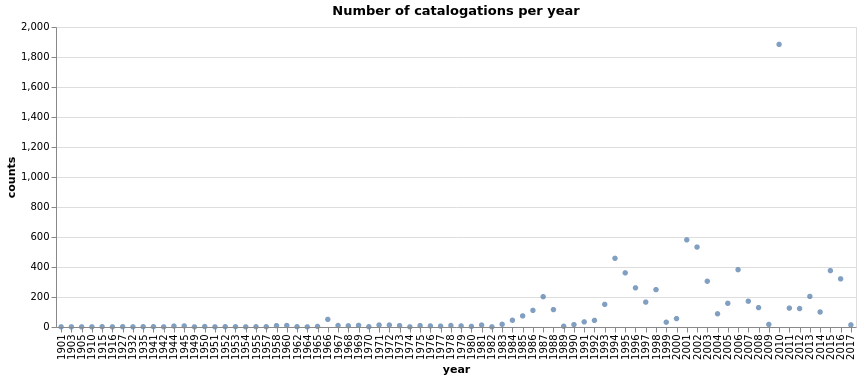

In [102]:
alt.Chart(data= teste, width=800, title= 'Number of catalogations per year').mark_circle().encode(
    x= alt.X('year', type='ordinal'),
    y= alt.Y('counts', type='quantitative')
)

<br>

### Types (*per year*)

x: Species1, cor: Type Status1, size: counts

#### adjusting columns `determined_year` e `cataloged_year` to ```*int*``` format 

In [103]:
def str_with_nan2int(string):
    if not np.isnan(string):
        return int(string)
    else:
        return np.NAN

In [104]:
# NewTable['determined_year'] = NewTable['determined_year'].apply(str_with_nan2int) #has NaN
NewTable['determined_year'] = NewTable['determined_year'].astype(int)
NewTable['cataloged_year'] = NewTable['cataloged_year'].astype(int)

#### removing duplicated rows as we took a subset of the main database

In [105]:
teste1 = NewTable.drop_duplicates().copy()  # remvoves duplicated rows (with same values in ALL columns)
print('Duplicated registers:',NewTable.shape[0] - NewTable.drop_duplicates().shape[0])
# teste1.head(2)

Duplicated registers: 10080


#### sorting for y axis (researchers  are listed by their first year of contribution)

In [106]:
teste1.sort_values(['determined_year','determiner_first_and_last_name'], inplace=True)

In [107]:
# names ordering for y axis
names_ordering = list(
    teste1[~teste1['determiner_first_and_last_name'].isna()]['determiner_first_and_last_name'].unique()
)

<br>

<font color='red' size='4'>**p.s.:** there are overlapping dots in the following graph. For each year, some researchers did catalog more than one *specimen* of different types. </font>

In [109]:
g1 = alt.Chart(teste1, width=800, height=2200).mark_circle().encode(
    x= alt.X('determined_year', type='ordinal', title='Year'),
    y= alt.Y('determiner_first_and_last_name', type='nominal', title='Determiner Name',
            sort= names_ordering),
    color= alt.Color('type_status')
)

# # salvando o gráfico
# g1.save('./viz/1-determiner_and_year-null_name.svg')
# g1.save('./viz/1-determiner_and_year-null_name.html')

# g1

<br>

#### adjustements: removing empty names and types

In [110]:
g1 = alt.Chart(teste1[~teste1['determiner_first_and_last_name'].isna() & (~teste1['determined_year'].isna())],
               width=800, height=2200).mark_circle().encode(
    x= alt.X('determined_year', type='ordinal', title='Year'),
    y= alt.Y('determiner_first_and_last_name', type='nominal', title='Determiner Name',
            sort= names_ordering),
    color= alt.Color('type_status')
)

# salvando o gráfico
# g1.save('./viz/2-determiner_and_year-null_type.svg')
# g1.save('./viz/2-determiner_and_year-null_type.html')

# g1

<br>

#### ordering per holotype year (year in which the holotype was discovered)

In [111]:
counts = teste1.groupby(['determiner_first_and_last_name', 'type_status','holotipo_year']).count()['class'].reset_index()
counts.rename(columns={'class':'counts'}, inplace=True)

In [112]:
teste1 = pd.merge(teste1, counts, on=['determiner_first_and_last_name', 'type_status','holotipo_year'])

In [113]:
teste1.sort_values(['holotipo_year','determiner_first_and_last_name', 'counts'], inplace=True)

In [114]:
# ordem do eixo y
names_ordering = list(
    teste1[(~teste1['determiner_first_and_last_name'].isna()) & (~teste1['type_status'].isna())]['determiner_first_and_last_name'].unique()
)

In [115]:
g1 = alt.Chart(teste1[(~teste1['determiner_first_and_last_name'].isna()) & (~teste1['type_status'].isna())],
               width=800, height=800).mark_circle().encode(
    x= alt.X('determined_year', type='ordinal', title='Year'),
    y= alt.Y('determiner_first_and_last_name', type='nominal', title='Determiner Name',
            sort= names_ordering),
    color= alt.Color('type_status'),
#     size=alt.Size('depth')
)

# salvando o gráfico
# g1.save('./viz/2-determiner_and_year-cor.svg')
# g1.save('./viz/2-determiner_and_year-cor.html')

# g1

In [116]:
colors = ['#d62728', '#f58518', '#d95f02',
          '#d62729', '#f58519', '#d95f03',
          '#4daf4a', '#8c6d31',
          '#79706e', '#bab0ac', '#d8b5a5'
         ]

types = ['Holotipo', 'Alotipo', 'Neotipo',
          'Sintipo', 'Lectotipo', 'Paralectotipo',
          'Paratipo', 'Topotipo', 
          'Tipo', 'Co-tipo', 'Material tipo'
        ]

opacities= [1, 1, 1,
           0.4,0.4,0.4,
           1,1,1,
           1,1,1]

# creating dictionary with type:color
type_color = defaultdict()
for t in range(len(types)):
    type_color[types[t]] = colors[t] 

In [117]:
# OBS: ainda há pontos sobrepostos (está afetando a opacidade)
g1 = alt.Chart(teste1[(~teste1['determiner_first_and_last_name'].isna()) & (~teste1['type_status'].isna())],
               width=800, height=800).mark_circle(size=60).encode(
    x= alt.X('determined_year', type='ordinal', title='Year'),
    y= alt.Y('determiner_first_and_last_name', type='nominal', title='Determiner Name',
            sort= names_ordering),
    color= alt.Color('type_status', legend= alt.Legend(title='Type Status'),
                     sort=types,
                     scale= alt.Scale(domain=types,range=colors)
                  ),
    tooltip= alt.Tooltip(['determiner_first_and_last_name','determined_year','type_status','holotipo_year']),
    opacity= alt.Opacity(scale= alt.Scale(domain=types,range=opacities), type='quantitative')
#     size=alt.Size('depth')
)

# salvando o gráfico
# g1.save('./viz/2-determiner_and_year_ordered_per_holotype_discover_yr.svg')
# g1.save('./viz/2-determiner_and_year_ordered_per_holotype_discover_yr.html')

# g1

<font color='green' size='5'>**OBS:** defining `UniqueTable` as a copy of unique registers of NewTable (slice of the original database)

In [118]:
# UniqueTable = NewTable.drop_duplicates().copy()
# teste = UniqueTable.groupby(['order','determined_year', 'type_status']).count()['count'].reset_index()

In [129]:
holotipo = teste1[(teste1['type_status'] == 'Holotipo')].copy()  # filtrando apenas holótipo
holotipo = holotipo[~holotipo['determiner_first_and_last_name'].isna()].copy()  # garantindo que os nomes 
#                                                                                não estão vazios...
# ordenando
holotipo.sort_values('holotipo_year', inplace=True)

#ordering per holotipo year
names_ordering = list(holotipo['determiner_first_and_last_name'].values)

temp = holotipo.groupby(['order','determined_year']).count()['count'].reset_index()

In [130]:
# OBS: ainda há pontos sobrepostos (está afetando a opacidade)
g1 = alt.Chart(holotipo,
               width=800, height=1200, title='Number of holotypes of each order per year').mark_circle(size=60,
                                                                                    color='red').encode(
    x= alt.X('determined_year', type='ordinal', title='Determined Year'),
    y= alt.Y('genus_and_species', type='nominal', title='Species')
)

g2 = alt.Chart(holotipo,
               width=680, height=1200, title='Number of holotypes of each order per year').mark_circle(size=60,
                                                                                    color='blue').encode(
    x= alt.X('holotipo_year', type='ordinal', title='Holotype Year'),
    y= alt.Y('genus_and_species', type='nominal', title='Species')
)

# salvando o gráfico
# g1.save('./viz/holotypes_per_order.svg')
# g1.save('./viz/holotypes_per_order.html')

# g1 + g2

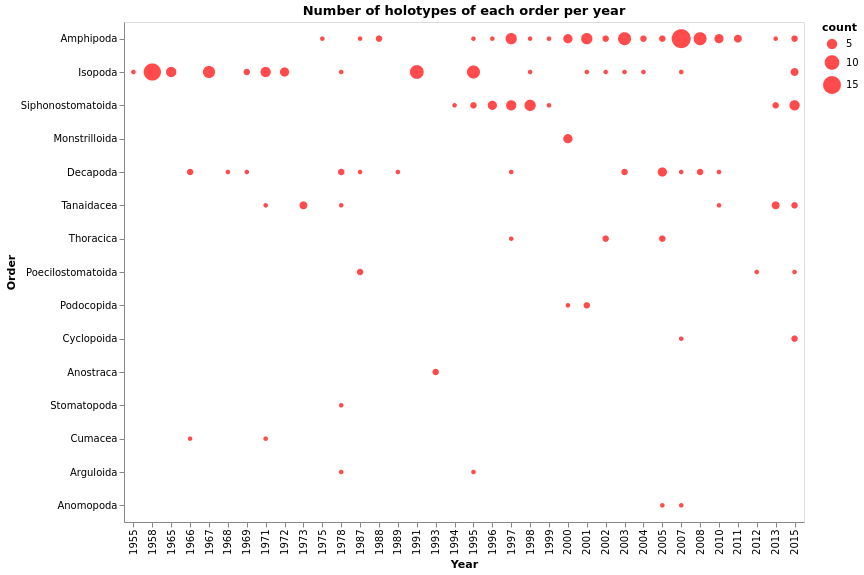

In [131]:
g1 = alt.Chart(temp[temp['order'] != 'Nan'],
               width=680, height=500, title='Number of holotypes of each order per year').mark_circle(size=60,
                                                                                color='red').encode(
    x= alt.X('determined_year', type='ordinal', title='Year'),
    y= alt.Y('order', type='nominal', title='Order',
            sort= alt.EncodingSortField(field='count', op='max', order='descending')),
    size = alt.Size('count'),
)

# salvando o gráfico
# g1.save(f'./viz/types/holotypes_per_order.svg')
# g1.save(f'./viz/types/holotypes_per_order.html')

g1

separating and grouping types

In [142]:
types = teste1['type_status'].unique()

group_types = []
for t in types:
    if t not in ['Holotipo', 'Alotipo', 'Paratipo']:
        group_types.append(t)

In [190]:
# replicando para TODOS os tipos
for t in ['Holotipo', 'Alotipo', 'Paratipo']:
    # preparing data
    temp1 = teste1[(teste1['type_status'] == t)].copy()                   # filtrando apenas holótipo
    temp = temp1[~temp1['determiner_first_and_last_name'].isna()].copy()  # garantindo que os nomes 
                                                                          # não estão vazios...
    # ordenando
    temp.sort_values('holotipo_year', inplace=True)

    # ordering per holotipo year
    names_ordering = list(temp['determiner_first_and_last_name'].values)
    
    # grouping and counting per order and year
    temp = temp.groupby(['order','determined_year']).count()['count'].reset_index()

    ### Chart
    g1 = alt.Chart(temp[temp['order'] != 'Nan'],
                   width=680, height=500, title=f'Number of {t} of each order per year').mark_circle(size=60,
                                                                     color=f'{type_color[t]}').encode(
        x= alt.X('determined_year', type='ordinal', title='Year'),
        y= alt.Y('order', type='nominal', title='Order',
                sort= alt.EncodingSortField(field='count', op='count', order='descending')),
        size = alt.Size('count'),
    #     color= alt.Color('holotipo_year', type='quantitative', scale= alt.Scale(scheme='reds')), 
    #     opacity= alt.Opacity(scale= alt.Scale(domain=types,range=opacities), type='quantitative')
    #     size=alt.Size('depth')
    )

    # salvando o gráfico
#     g1.save(f'./viz/types/{t}_per_order.svg')
#     g1.save(f'./viz/types/{t}_per_order.html')

# g1

In [191]:
t = teste1['order'].unique()

In [192]:
temp = teste1[(teste1['order'] != 'Nan') & (teste1['type_status'].isin(group_types))]
temp = temp.groupby(['order','determined_year','type_status']).count()['count'].reset_index()

In [193]:
colors = ['']

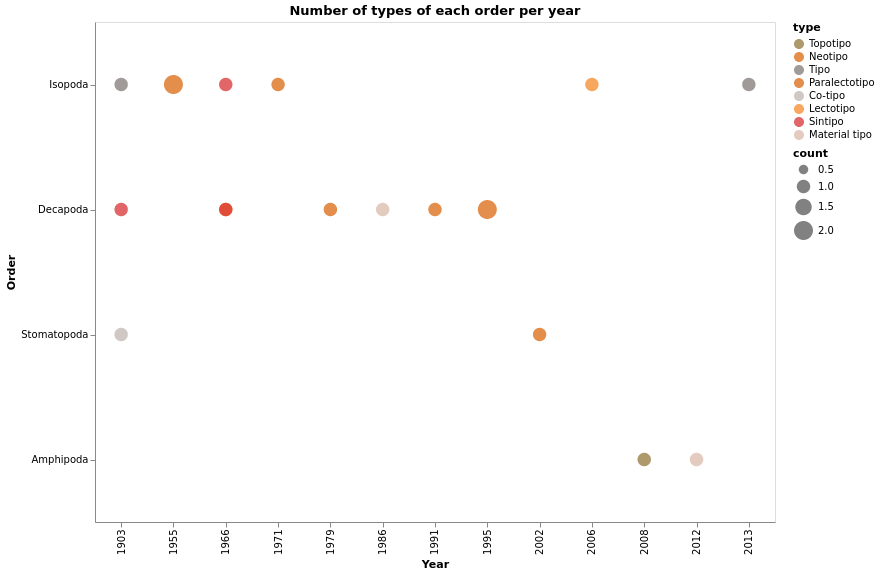

In [194]:
# making graph for other types (group_types)
g1 = alt.Chart(temp,
               width=680, height=500, title='Number of types of each order per year').mark_circle(
                                                                                size=60).encode(
    x= alt.X('determined_year', type='ordinal', title='Year'),
    y= alt.Y('order', type='nominal', title='Order',
            sort= alt.EncodingSortField(field='count', op='max', order='descending')),
    color= alt.Color('type_status', title='type',
                     scale= alt.Scale(domain=group_types,range=[type_color[t] for t in group_types])),
    size = alt.Size('count', type='quantitative', scale = alt.Scale(type='bin-ordinal')),
)

# salvando o gráfico
g1.save(f'./viz/types/other-types_per_order.svg')
g1.save(f'./viz/types/other-types_per_order.html')

g1

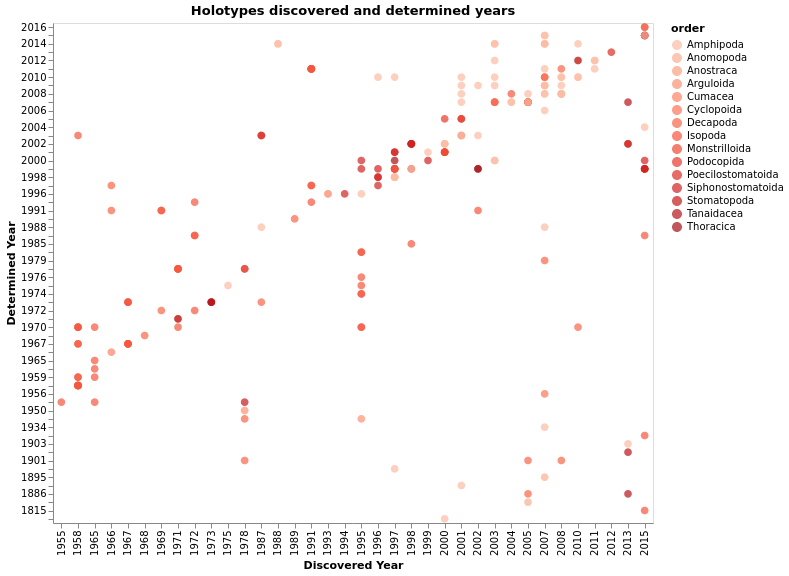

In [195]:
#### MARCAR NANs de preto
# OBS: ainda há pontos sobrepostos (está afetando a opacidade)
g1 = alt.Chart(holotipo, title='Holotypes discovered and determined years',
               width=600, height=500).mark_circle(size=60).encode(
    x= alt.X('determined_year', type='ordinal', title='Discovered Year'),
    y= alt.Y('holotipo_year', type='ordinal', title='Determined Year',
            sort= alt.EncodingSortField(field='holotipo_year', order='descending')),
    tooltip= alt.Tooltip(['holotipo_year', 'determined_year']),
    color= alt.Color('order', type='nominal', scale= alt.Scale(scheme='reds')), 
#     opacity= alt.Opacity(scale= alt.Scale(domain=types,range=opacities), type='quantitative')
#     size=alt.Size('depth')
)

# salvando o gráfico
# g1.save('./viz/types/holotipo_cataloged_and_determined_year.svg')
# g1.save('./viz/types/holotipo_cataloged_and_determined_year.html')

g1

<br>

### types per species

In [197]:
orders = teste1['order'].unique()

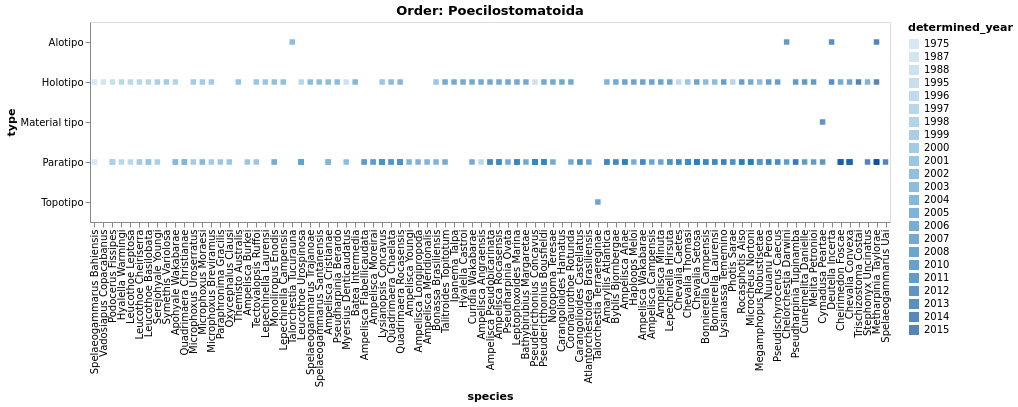

In [200]:
g2 = alt.Chart(teste1[teste1['order'] == 'Amphipoda'], title=f'Order: {order}',width=800, height=200).mark_square().encode(
    y= alt.Y('type_status', type='nominal', title='type'),
    x= alt.X('genus_and_species', type='nominal', title='species', 
             sort= alt.EncodingSortField('determined_year', op='max',order='ascending')),
    color= alt.Color('determined_year', type='ordinal')
)

# salvando o gráfico
# g2.save('./viz/orders/determiner_and_species.svg')
# g2.save('./viz/orders/determiner_and_species.html')

g2

In [ ]:
# creating graphs for all orders
for order in orders:
    g2 = alt.Chart(teste1[teste1['order'] == order], title=f'Order: {order}',width=800, height=200).mark_square().encode(
        y= alt.Y('type_status', type='nominal', title='Type'),
        x= alt.X('genus_and_species', type='nominal', title='Species', 
                 sort= alt.EncodingSortField('determined_year', op='max',order='ascending')),
        color= alt.Color('determined_year', type='ordinal', title= 'Determined Year')
    )

    # salvando o gráfico
    g2.save(f'./viz/orders/{order}_per_types.svg')
    g2.save(f'./viz/orders/{order}_per_types.html')

g2

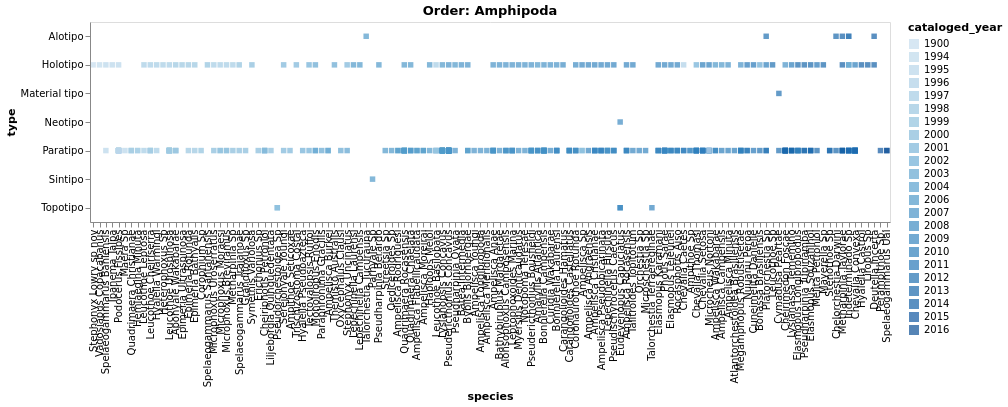

In [204]:
# ordem filtrada e cataloged year como cor
g2 = alt.Chart(NewTable[(NewTable['order'] == 'Amphipoda') & (~NewTable['type_status'].isna())],
               title='Order: Amphipoda',width=800, height=200).mark_square().encode(
    y= alt.Y('type_status', type='nominal', title='type'),
    x= alt.X('genus_and_species', type='nominal', title='species', 
             sort= alt.EncodingSortField('cataloged_year', op='max',order='ascending')),
    color= alt.Color('cataloged_year', type='ordinal')
)

# salvando o gráfico
# g2.save('./viz/determiner_and_species.svg')
# g2.save('./viz/determiner_and_species.html')

g2

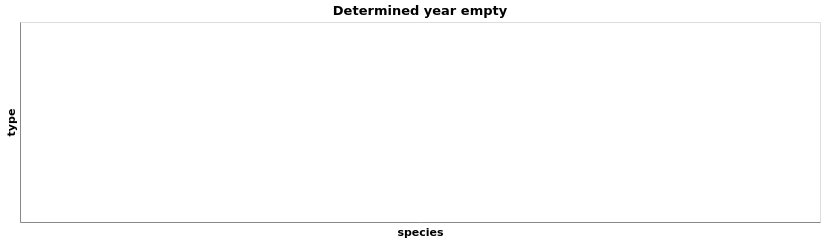

In [203]:
# types and order non-empty and determined year empty (CHECK YEAR COLUMNS)
g2 = alt.Chart(NewTable[(NewTable['determined_year'].isna()) & (~NewTable['type_status'].isna())],
               title='Determined year empty',width=800, height=200).mark_square().encode(
    y= alt.Y('type_status', type='nominal', title='type'),
    x= alt.X('genus_and_species', type='nominal', title='species', 
             sort= alt.EncodingSortField('determined_year', op='max',order='ascending')),
#     color= alt.Color('determined_year', type='ordinal')
)

# salvando o gráfico
# g2.save('./viz/determiner_and_species.svg')
# g2.save('./viz/determiner_and_species.html')

g2

<br>

### Profundidades

<font color='red'>**OBS:** Nesse gráfico ainda há pontos sobrepostos. Pensar como corrigir isso... </font>

In [282]:
# calculando extremos para o eixo y
l = []
for depth in teste1[~teste1['type_status'].isna()]['depth']:
    try:
        l.append(float(depth))
    except:
        pass
    
max_y = max(l)
min_y = min(l)

In [284]:
# contango catalog. por ano, type e profundidade.
t = teste1.groupby(['determined_year','type_status','depth', 'count']).count()['class'].reset_index()
t.rename(columns={'class':'reg_counts'}, inplace=True)
t['type_status'].isna().sum()  # nenhum NaN

0

In [ ]:
g3 = alt.Chart(t, width=600, title='').mark_circle().encode(
    x= alt.X('year', type='ordinal', title='Year'),
    y= alt.Y('depth', type='quantitative', title='Depth', scale=alt.Scale(domain=[max_y,min_y])),
    color= alt.Color('type_status', legend= alt.Legend(title='Type Status'),
                     sort=types,
                     scale= alt.Scale(domain=types,range=colors)
                  ),
    tooltip= alt.Tooltip('type_status'),
    opacity= alt.Opacity(scale= alt.Scale(domain=types,range=opacities), type='quantitative'),
    size=alt.Size('count',type= 'quantitative', legend=alt.Legend(title='Quantity'))
)

# salvando o gráfico
# g2.save('./viz/depth.svg')
# g2.save('./viz/depth.html')

g3

### Número de catalogações de cad tipo (por ano)

In [ ]:
# teste1 é construída a partir do df NewTable
type_data = teste1.groupby(['type_status','year']).count()['class'].reset_index().rename(
                                                    columns={'class':'counts'})

In [ ]:
type_data.sort_values(['counts'], inplace=True)

<font color='red' size='5'>**Anotar valores nas células**</font>

In [ ]:
g3 = alt.Chart(type_data, title='Number of animals of each type per year').mark_rect().encode(
    x= alt.X('year', type='ordinal', title='Year'),
    y= alt.Y('type_status', type='nominal', title='Type', 
             sort=alt.EncodingSortField(field="counts", op="mean", order='descending'),
            axis=alt.Axis(grid=False)),
    color= alt.Color('counts', type='quantitative', scale=alt.Scale(scheme='yellowgreenblue'))
)

g3.save('./viz/types_per_year.html')
g3.save('./viz/types_per_year.svg')

g3

<br>

-----

## Waffle Chart

In [ ]:
ex = pd.ExcelFile('Dados gerais de coleção MN_29_09_19 enviado KELLNER_Asla.xlsx')
print(ex.sheet_names)

In [ ]:
dados_gerais = ex.parse('Dados Gerais', sep=';', encoding='utf-8-sig')
dados_colecao = ex.parse('Dados por coleção', sep=';', encoding='utf-8-sig')

In [ ]:
dados_colecao.head(2)

In [ ]:
dc = dados_colecao[['Unnamed: 0', 'Coleção', 'número de exemplares tombados e backlog', 
               'Material afetado no incêndio (N)',
               'Material afetado no incêndio (% do total)', 'Unnamed: 7']].copy()

In [ ]:
dc.rename(columns={'Unnamed: 0':'dept', 'Coleção':'colecao', 
                   'número de exemplares tombados e backlog':'numero_exemp',
                   'Material afetado no incêndio (N)':'incendio', 
                    'Material afetado no incêndio (% do total)':'incendio_perc_total',
                    'Unnamed: 7':'incendio_perc_colecao'}, inplace=True)

In [ ]:
dc['dept'] = dc['dept'].str.upper().str.strip()
dc['dept'] = dc['dept'].str.replace('DIREÇÃO', 'Direção')

In [ ]:
dc['colecao'] = dc['colecao'].apply(lambda x:str(x).split('(')[0].strip())

In [ ]:
# mudanças para encurtar o nome das coleções (p/ caber no frame da figura)
dc['colecao'] = dc['colecao'].str.replace('Centro de Documentação', 'Doc.')
dc['colecao'] = dc['colecao'].str.replace('do Museu Nacional', '').str.strip()
dc['colecao'] = dc['colecao'].str.replace('Biblioteca', 'Bib.')
dc['colecao'] = dc['colecao'].str.replace('Coleção de','')
dc['colecao'] = dc['colecao'].str.replace('COFRE DIREÇÃO', 'Cofre')
dc['colecao'] = dc['colecao'].str.replace('Coleção Didática de', '')
dc['colecao'] = dc['colecao'].str.replace('Setor de', '')

# removendo espaços
dc['colecao'] = dc['colecao'].str.strip()

In [ ]:
# Figura padrão
fig1 = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    columns=10, 
    values=[84.556, 100-84.556],
    colors=("#826745", "#3EA447"),
    title={'label': 'Total', 'loc': 'center'},
    labels=["{0} ({1}%)".format(k, v) for k, v in (('Consumido no incendio','84.55'),('remanescente' ,'{}'.format(round(100-84.55,2))))],
#     labels=["{0}".format(k) for k in ['consumido no incendio', 'remanescente']],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icon_size=18,
    icon_legend=True,
#     legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    figsize=(10, 6)  # figsize is a parameter of matplotlib.pyplot.figure
)
plt.show()

In [ ]:
# Figura padrão
fig2 = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    columns=10, 
    values=[84.556, 100-84.556],
    colors=("#826745", "#3EA447"),
    title={'label': 'Total', 'loc': 'center', 'fontsize':18},
    labels=["{0} ({1}%)".format(k, v) for k, v in (('Consumido no incendio','84.55'),('Remanescente' ,'{}'.format(round(100-84.55,2))))],
#     labels=["{0}".format(k) for k in ['consumido no incendio', 'remanescente']],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icon_size=18,
    icon_legend=True,
    vertical=True,
#     icons=['fire','square'],  # fire, campfire, heart, heart-o - OBS: pode passar a ideia errada,
#     characters='⬤',
#     font_size=30,
    figsize=(10, 6)  # figsize is a parameter of matplotlib.pyplot.figure
)
# plt.show()

plt.savefig('./viz/waffles/total.svg')
plt.savefig('./viz/waffles/total.png')

### criando dicionários para plot
cada linha deve ser um departamento, e cada coluna uma coleção

In [ ]:
# dc.head()

In [ ]:
# lista de departamentos ordenada de acordo com o número de coleções
deptos = dc['dept'].value_counts().sort_values(ascending=True).index

### corrigindo alguns nomes de coleção (input do especialista)

A correção desses nomes foi sugerida diretamente pela Cris.

In [ ]:
# dicionário com os nomes corretos 
nomes_colecao = {'Lepdóptera':'Lepdoptera', 'Poríferos':'Porífera'}

# se o nome já está correto, basta retorná-lo
def corrige_nome_colecao(colecao):
    try:
        return nomes_colecao[colecao]
    except:
        return colecao

# redefinindo a coluna
dc['colecao'] = dc['colecao'].apply(lambda x:corrige_nome_colecao(x))

### Definindo coleções recuperáveis e criando os `Waffle Charts`

In [ ]:
# dc['colecao'].unique()

In [ ]:
# criando lista de colecoes recuperáveis:
colecoes_recuperaveis = ('Antropologia Biológica', 'Etnográficas', 'Arqueológica', 'Malacologia', 
                         'Paleovertebrados', 'Paleoinvertebrados', 'Mineralogia', 'Petrografia', 'Meteoritos')

#### criando dicionário ("json") para ser passado para o modo "multichart" da biblioteca Pywaffle

In [ ]:
# cria coluna de colecoes recuperáveis
def recuperavel(colecao):
    if colecao in colecoes_recuperaveis:
        return True
    else:
        return False

In [ ]:
dc['recup'] = dc['colecao'].apply(recuperavel)

In [ ]:
# ordenando tabela de acordo com o % de elementos recuperados
dc.sort_values(['dept','incendio_perc_colecao','recup'], ascending=True, inplace=True)

In [ ]:
# for para dept
# for para colecao
# dict padrao
d = defaultdict()

index=0
adj = 0  # valor para ajuste das linhas (número de colunas para pular se acabar as coleções por depto)
for dept in deptos:
    temp = dc[dc['dept']==dept].sort_values('incendio_perc_colecao', ascending=False)
    
    row_count = temp.shape[0] # aumenta a linha com o número de dept
#     print(temp,'\n\n')
    adj = 10
    for c in range(temp['colecao'].shape[0]):
        
        adj -= 1
        index += 1
        val = round(temp.iloc[c].loc['incendio_perc_colecao'], 2)
        colecao = temp.iloc[c].loc['colecao']
        numero_exemp = temp.iloc[c].loc['numero_exemp'].astype(int)
        
        # definindo cores:
        cor_verde = '#3EA447'
        cor_marrom = '#826745'
        if colecao in colecoes_recuperaveis:
            cor_marrom = '#B6966E'
        
        # criando dicionário para o gráfico
        d[(7,10,index)]= { 
                    'values':[val, 100-val],
                    'colors':(cor_marrom, cor_verde),
                    # OBS: separador de milhar está como vírgula: ,
                    'title':{'label': f'{dept}\n{colecao}\n{numero_exemp:,} exemplares'.replace(',','.')
                             , 'loc': 'left', 'fontsize':14},
#                   'labels':["{0} ({1}%)".format(k, v) for k, v in data.items()],
#                   'labels':["{0}".format(k) for k in ['% da colecao consumida no incendio', '% remanescente da coleção']],
#                   'legend':{'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
#                   'icon_size':18, 
                    'icon_legend':True,
        }
    
        
        # pulando para a próxima linha
        if c == temp['colecao'].shape[0]-1:
            index = index + adj
        
d = dict(d)
# d

#### Criando os `waffle charts`

In [ ]:
teste = plt.figure(
    FigureClass= Waffle,
    plots= d,
    rows=10, 
    columns=10, 
    vertical=True, 
    block_aspect_ratio=1.2,
    figsize=(35, 35)  # figsize is a parameter of matplotlib.pyplot.figure
)

plt.savefig('./viz/waffles/waffle_colecao.svg')
plt.savefig('./viz/waffles/waffle_colecao.png')

**<font color='red' size='5'>Ajustes</font>**

- idealmente, o nome do departamento deveria ficar nas colunas (editar o svg)
- adicionar legenda

-----

### Gráfico de barras

Esse gráfico, a pedido da Cris, tem a intenção de exibir as quantidades absolutas perdidas e recuperadas no incêndio.

In [ ]:
temp = dc.copy()
temp['dept'].fillna('Total', inplace=True)

del temp['recup']

In [ ]:
temp['Remanescentes'] = temp['numero_exemp'].astype(int) - temp['incendio'].astype(int)

In [ ]:
temp = temp.rename(columns={'numero_exemp':'Total', 'incendio':'Consumidos'})

In [ ]:
temp = temp.set_index(['colecao','incendio_perc_total','incendio_perc_colecao'])
temp = temp.groupby(['dept']).sum().stack().reset_index()
temp.columns = ['dept','nivel','num']

In [ ]:
# temp.head()

In [ ]:
bar1 = alt.Chart(temp).mark_bar().encode(
    x = alt.X('nivel', sort= alt.EncodingSortField(field="nivel", op="mean", order='ascending'),
             title='', axis=alt.Axis(labelAngle=-60)),
    y= alt.Y('num', title='Contagem'), 
    color= alt.Color('nivel', scale= 
            alt.Scale(domain=['Total','Consumidos','Remanescentes'], 
                      range=['#c2b9b0','#826745','#3EA447'])
        , title=''),
    column=alt.Column('dept', sort= ['Total','DE','Direção','DV','DA','DI','DB','DGP'],
                     title='Número de exemplates tombados por departamento')
)

bar1.save('./viz/waffles/exemp_por_dept.svg')
bar1.save('./viz/waffles/exemp_por_dept.html')

bar1

<br>

**Fim!**

-----